<a href="https://colab.research.google.com/github/Odaenethus/CFD-simulations-google-collab-/blob/main/assignment_8_SFD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy

step 0/80000  max|V|=4.8652e-06  max(T)=50.00
step 10000/80000  max|V|=1.0238e-02  max(T)=50.00
step 20000/80000  max|V|=1.5350e-02  max(T)=50.00
step 30000/80000  max|V|=1.9016e-02  max(T)=50.00
step 40000/80000  max|V|=2.2582e-02  max(T)=50.00
step 50000/80000  max|V|=2.6101e-02  max(T)=50.00
step 60000/80000  max|V|=2.9309e-02  max(T)=50.00
step 70000/80000  max|V|=3.2303e-02  max(T)=50.00


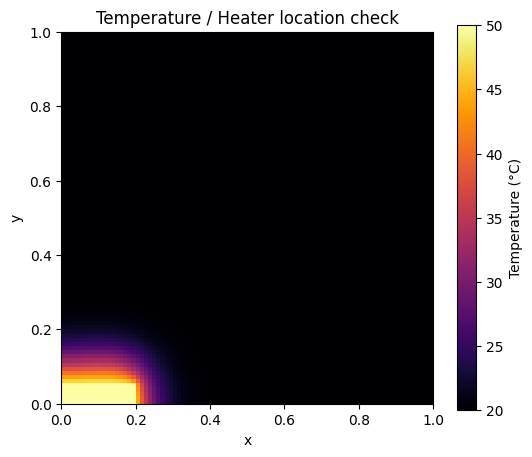

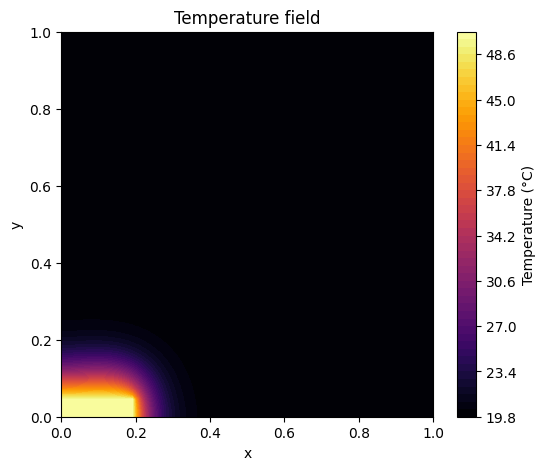

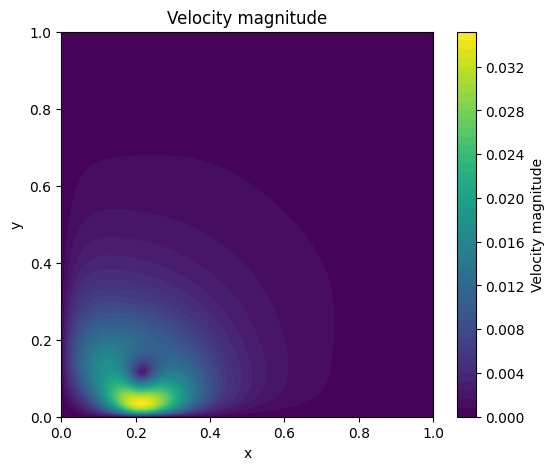

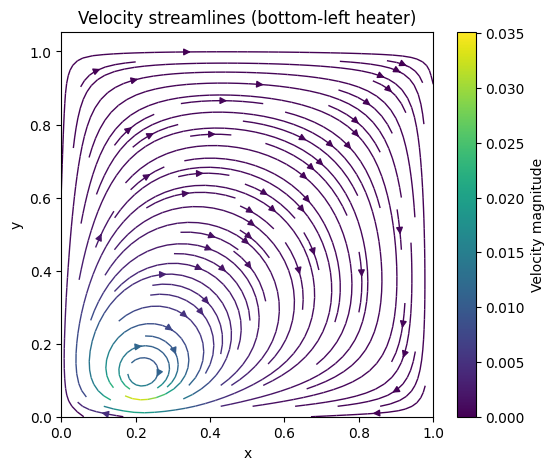

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 2D Natural Convection in a square cavity (Boussinesq)
# Incompressible Navier-Stokes + Energy equation
# Projection method (pressure Poisson)
# Heater: bottom-left patch at fixed temperature Th
# Other walls: adiabatic (dT/dn = 0)
# Walls: no-slip (u=v=0)
# Upwind advection for stability/smooth streamlines
# ============================================================

# -------------------------------
# Domain & grid
# -------------------------------
Lx, Ly = 1.0, 1.0
Nx, Ny = 90, 90                 # smaller grid (faster)
dx, dy = Lx/(Nx-1), Ly/(Ny-1)
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)

# -------------------------------
# Time
# -------------------------------
dt = 2e-5
nt = 80000                      # more time
poisson_iters = 100             # pressure iterations per step

# -------------------------------
# Physics (stable/laminar)
# -------------------------------
nu    = 2e-3     # viscosity
alpha = 2e-3     # thermal diffusivity
beta  = 1e-3     # expansion coefficient
g     = 9.81

T0 = 20.0
Th = 50.0

# -------------------------------
# Fields (Ny, Nx)
# -------------------------------
u = np.zeros((Ny, Nx))
v = np.zeros((Ny, Nx))
p = np.zeros((Ny, Nx))
T = T0 * np.ones((Ny, Nx))

# -------------------------------
# Heater definition (bottom-left patch)
# -------------------------------
heater_width  = int(0.20 * Nx)   # 20% of bottom length
heater_height = int(0.06 * Ny)   # small block height (looks more "real")

def apply_velocity_bc(u, v):
    # no-slip everywhere
    u[:, 0] = 0.0; u[:, -1] = 0.0; u[0, :] = 0.0; u[-1, :] = 0.0
    v[:, 0] = 0.0; v[:, -1] = 0.0; v[0, :] = 0.0; v[-1, :] = 0.0
    return u, v

def apply_temperature_bc(T):
    # adiabatic walls (Neumann): copy adjacent interior value
    T[:, 0]  = T[:, 1]     # left
    T[:, -1] = T[:, -2]    # right
    T[0, :]  = T[1, :]     # bottom
    T[-1, :] = T[-2, :]    # top

    # heater (Dirichlet)
    T[0:heater_height, 0:heater_width] = Th
    return T

T = apply_temperature_bc(T)

# -------------------------------
# Operators
# -------------------------------
def laplacian(f):
    return (
        (f[1:-1,2:] - 2*f[1:-1,1:-1] + f[1:-1,:-2]) / dx**2 +
        (f[2:,1:-1] - 2*f[1:-1,1:-1] + f[:-2,1:-1]) / dy**2
    )

def divergence(u, v):
    return (
        (u[1:-1,2:] - u[1:-1,:-2])/(2*dx) +
        (v[2:,1:-1] - v[:-2,1:-1])/(2*dy)
    )

# Upwind derivatives for stability
def upwind_dx(phi, u_center):
    d = np.zeros_like(phi)
    back = (phi[:,1:-1] - phi[:,0:-2]) / dx
    fwd  = (phi[:,2:  ] - phi[:,1:-1]) / dx
    uc   = u_center[:,1:-1]
    d[:,1:-1] = np.where(uc >= 0, back, fwd)
    return d

def upwind_dy(phi, v_center):
    d = np.zeros_like(phi)
    back = (phi[1:-1,:] - phi[0:-2,:]) / dy
    fwd  = (phi[2:  ,:] - phi[1:-1,:]) / dy
    vc   = v_center[1:-1,:]
    d[1:-1,:] = np.where(vc >= 0, back, fwd)
    return d

# -------------------------------
# Time loop
# -------------------------------
for n in range(nt):
    un = u.copy()
    vn = v.copy()
    Tn = T.copy()

    # ---- Predictor (no pressure) ----
    du_dx = upwind_dx(un, un)
    du_dy = upwind_dy(un, vn)
    dv_dx = upwind_dx(vn, un)
    dv_dy = upwind_dy(vn, vn)

    u[1:-1,1:-1] = (
        un[1:-1,1:-1]
        - dt*( un[1:-1,1:-1]*du_dx[1:-1,1:-1] + vn[1:-1,1:-1]*du_dy[1:-1,1:-1] )
        + nu*dt*laplacian(un)
    )

    # Buoyancy term: g * beta * (T - T0)  ✅ (temperature multiplied)
    buoy = g * beta * (Tn[1:-1,1:-1] - T0)

    v[1:-1,1:-1] = (
        vn[1:-1,1:-1]
        - dt*( un[1:-1,1:-1]*dv_dx[1:-1,1:-1] + vn[1:-1,1:-1]*dv_dy[1:-1,1:-1] )
        + nu*dt*laplacian(vn)
        + dt*buoy
    )

    # velocity BCs
    u, v = apply_velocity_bc(u, v)

    # ---- Pressure Poisson ----
    rhs = divergence(u, v) / dt

    for _ in range(poisson_iters):
        p[1:-1,1:-1] = 0.25 * (
            p[1:-1,2:] + p[1:-1,:-2] + p[2:,1:-1] + p[:-2,1:-1]
            - (dx*dy)*rhs
        )
        # Neumann pressure BCs (dp/dn=0) + gauge fix
        p[:, 0]  = p[:, 1]
        p[:, -1] = p[:, -2]
        p[0, :]  = p[1, :]
        p[-1, :] = p[-2, :]
        p[0, 0] = 0.0

    # ---- Correct velocities ----
    u[1:-1,1:-1] -= dt*(p[1:-1,2:] - p[1:-1,:-2])/(2*dx)
    v[1:-1,1:-1] -= dt*(p[2:,1:-1] - p[:-2,1:-1])/(2*dy)

    # re-apply no-slip
    u, v = apply_velocity_bc(u, v)

    # ---- Temperature update ----
    dT_dx = upwind_dx(Tn, un)
    dT_dy = upwind_dy(Tn, vn)

    T[1:-1,1:-1] = (
        Tn[1:-1,1:-1]
        - dt*( un[1:-1,1:-1]*dT_dx[1:-1,1:-1] + vn[1:-1,1:-1]*dT_dy[1:-1,1:-1] )
        + alpha*dt*laplacian(Tn)
    )

    # temperature BCs (adiabatic + heater)
    T = apply_temperature_bc(T)

    if n % 10000 == 0:
        speed = np.sqrt(u*u + v*v)
        print(f"step {n}/{nt}  max|V|={np.max(speed):.4e}  max(T)={np.max(T):.2f}")

# -------------------------------
# Plots
# -------------------------------
# Heater check
plt.figure(figsize=(6,5))
plt.imshow(T, origin="lower", extent=[0,1,0,1], aspect="equal", cmap="inferno")
plt.colorbar(label="Temperature (°C)")
plt.title("Temperature / Heater location check")
plt.xlabel("x"); plt.ylabel("y")
plt.show()

# Temperature contour
plt.figure(figsize=(6,5))
plt.contourf(x, y, T, 50, cmap="inferno")
plt.colorbar(label="Temperature (°C)")
plt.title("Temperature field")
plt.xlabel("x"); plt.ylabel("y")
plt.show()

# Velocity magnitude contour
U = np.sqrt(u*u + v*v)
plt.figure(figsize=(6,5))
plt.contourf(x, y, U, 50)
plt.colorbar(label="Velocity magnitude")
plt.title("Velocity magnitude")
plt.xlabel("x"); plt.ylabel("y")
plt.show()

# Streamlines (NO transpose; u,v are (Ny,Nx))
plt.figure(figsize=(6,5))
plt.streamplot(x, y, u, v, density=1.2, color=U, linewidth=1.0)
plt.colorbar(label="Velocity magnitude")
plt.title("Velocity streamlines (bottom-left heater)")
plt.xlabel("x"); plt.ylabel("y")
plt.show()


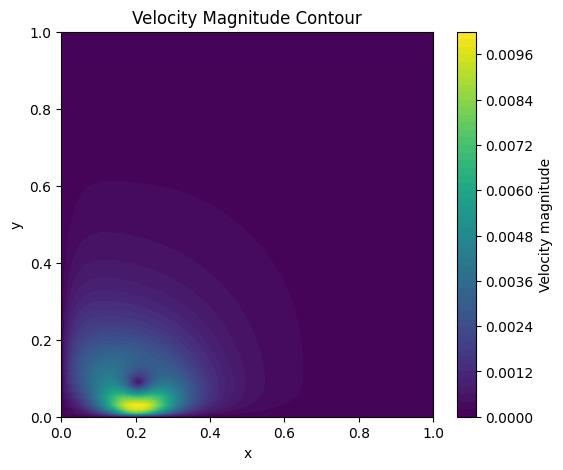

In [ ]:
# Velocity magnitude
U = np.sqrt(u**2 + v**2)

plt.figure(figsize=(6,5))
plt.contourf(x, y, U, 50, cmap='viridis')
plt.colorbar(label='Velocity magnitude')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Velocity Magnitude Contour')
plt.show()


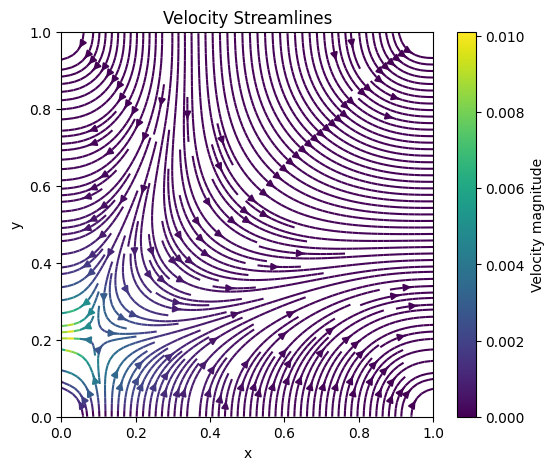

In [ ]:
plt.figure(figsize=(6,5))
plt.streamplot(
    x, y,
    u.T, v.T,
    density=2,
    color=np.sqrt(u.T**2 + v.T**2),
    cmap='viridis'
)
plt.colorbar(label='Velocity magnitude')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Velocity Streamlines')
plt.show()


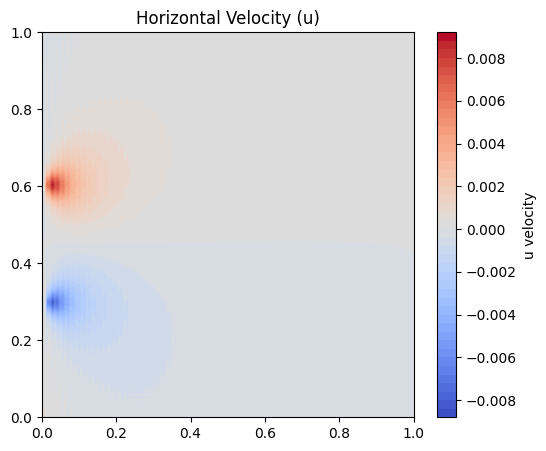

In [ ]:
plt.figure(figsize=(6,5))
plt.contourf(x, y, u, 50, cmap='coolwarm')
plt.colorbar(label='u velocity')
plt.title('Horizontal Velocity (u)')
plt.show()


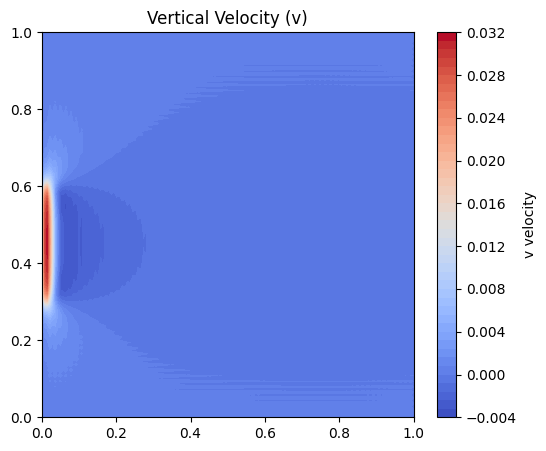

In [ ]:
plt.figure(figsize=(6,5))
plt.contourf(x, y, v, 50, cmap='coolwarm')
plt.colorbar(label='v velocity')
plt.title('Vertical Velocity (v)')
plt.show()
